In [1]:
import pandas as pd
import numpy as np
import time

In [2]:
pickup_data = pd.read_pickle('arrival_and_dropoff_distributions')
hourly_arrival_rate =  pickup_data.apply(lambda item: item[0])
dropoff_frequency  = pickup_data.apply(lambda  item: item[1] / item[1].sum())
trip_time_data = pd.read_csv('trip_time_means.csv', index_col = 'pulocationid')
trip_time_data.columns = trip_time_data.columns.astype(int)

In [3]:
trip_time_data

,1,2,3,4,5,6,7,8,9,10,...,254,255,256,257,258,259,260,261,262,263
pulocationid,,,,,,,,,,,,,,,,,,,,,
1,19.037500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,54.540476,NaN,5.167347,43.009259,NaN,NaN,26.164216,NaN,21.255556,28.980556,...,8.283445,36.853333,50.141667,NaN,29.909524,12.957595,25.814583,36.427778,29.962821,31.922222
4,38.440143,NaN,36.005556,8.353476,39.816667,30.175000,25.623986,NaN,32.711111,34.955556,...,32.131944,17.887951,15.287944,21.346354,38.314286,31.405556,22.180637,14.926667,17.628817,18.310448
5,26.337016,NaN,NaN,NaN,6.377981,26.475439,NaN,NaN,NaN,63.383333,...,NaN,41.983333,NaN,NaN,NaN,NaN,NaN,45.066667,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,51.784091,NaN,13.075407,41.887500,NaN,NaN,25.589524,NaN,NaN,34.687500,...,7.817611,38.598958,41.022222,66.283333,45.880392,5.406855,30.971930,50.381818,29.982639,29.974074
260,50.356373,NaN,29.951515,24.593915,NaN,NaN,9.541995,12.531944,21.596930,27.229938,...,28.170290,16.476681,17.322406,29.064583,26.097162,28.320238,6.141669,31.753922,23.707520,23.136458
261,38.053702,NaN,39.591667,14.067819,38.878571,22.952083,29.628744,NaN,35.214583,51.258974,...,39.840000,23.663167,21.626105,17.425219,40.557500,48.560000,26.953968,10.799706,22.717876,23.064069


In [ ]:
from tqdm import tqdm

def generate_arrivals_per_zone(zone_hourly_arrivals = hourly_arrival_rate, 
                               zone_dropoff_frequencies = dropoff_frequency, 
                               zone_to_zone_times = trip_time_data, 
                               one_list = True):
    
    #check to make sure the indices match
    assert (zone_hourly_arrivals.index == zone_dropoff_frequencies.index).all()
    assert (zone_hourly_arrivals.index == zone_to_zone_times.index).all()
    
    zone_arrivals = []
    #for each zone, generate a day's worth of arrivals
    for i in tqdm(zone_hourly_arrivals.index):
        
        hourly_rates = zone_hourly_arrivals.loc[i]
        dropoff_dist = zone_dropoff_frequencies.loc[i]
        zone_service_times = zone_to_zone_times.loc[i]
                
        max_rate = hourly_rates.max()
        #rate = max_rate / 60 minutes (since max_rate is in minutes)
        #input the inverse as the mean interarrival time (scale parameter for np.random.exponential)
        temp_interarrivals = np.random.exponential(scale = 60/max_rate, size = 25000)
        
        #this cuts off interarrivals at 1 day
        interarrivals = temp_interarrivals[temp_interarrivals.cumsum() <= 24*60]
        arrivals = interarrivals.cumsum()
                
        #thinning process
        #uses constant hourly rate (like a 24 part step function) to generate the thinning probabilities
        keep_probability = (hourly_rates[(arrivals // 60).astype(int)] / max_rate).values
        unif = np.random.uniform(size = arrivals.shape[0])
        kept_arrivals = arrivals[unif <= keep_probability]
                
        #for each arrival generate from the dropoff distribution
        dropoffs = np.random.choice(dropoff_dist.index, size = kept_arrivals.shape[0], p = dropoff_dist)
                              
        #generate data in the form of (time, dropoff location id, pickup location id)
        arrival_data = np.vstack([kept_arrivals, dropoffs, i*np.ones(kept_arrivals.shape[0])]).T
        
        #format into dataframe
        arrival_df = pd.DataFrame(data = arrival_data, columns = ['time','dolocationid','pulocationid'])
        
        #each arrival, generate a service time from the service time distributions
        #this is SLOW
        services = [np.random.exponential(mean) for mean in zone_service_times[arrival_df.dolocationid]]
                
        arrival_df['service'] = services
        
        zone_arrivals.append(arrival_df)
    
    #if one list, then combine everything into one big arrival matrix
    #otherwise, just return the list of arrival dataframes
    if one_list:
        zone_arrivals = pd.concat(zone_arrivals).sort_values('time').reset_index(drop=True)
    
    return zone_arrivals

In [ ]:
arrivals = generate_arrivals_per_zone()

100%|████████████████████████████████████████| 259/259 [00:01<00:00, 138.30it/s]


In [39]:
from collections import deque

class Driver:
    
    #can add behaviors here like time schedule, max distance allowed
    def __init__(self, start_zone):
        self.passenger = None
        self.passenger_queue = deque()
        self.movement_history = [[0, start_zone, self.passenger]]
    
    def add_passenger(self, passenger):
        self.passenger_queue.append(passenger)
        
    def pop_next_passenger(self):
        if len(self.passenger_queue) == 0:
            return None
        return self.passenger_queue.popleft()
    
    def get_next_passenger(self):
        if len(self.passenger_queue) == 0:
            return None
        return self.passenger_queue[0]
    
    def add_movement(self, start_time, destination, passenger = None):
        self.movement_history.append([start_time, destination, passenger])
    
    def status(self):
        return 'In Transit' if self.passenger is not None or len(self.passenger_queue) > 0 else 'Idle'
    
    def hit_maximum_passenger_queue_size(self, max_size = 2):
        return len(self.passenger_queue) >= max_size
    
    def __str__(self):
        if self.destination is not None:
            return f'In Transit to {self.destination} from {self.location} with {len(self.passenger_queue)} waiting passengers'
        else:
            return f'Currently at {self.location}'
    
class Passenger:
    
    def __init__(self, arrival_time, start_zone, end_zone, service_time):
        self.time = arrival_time
        self.start = int(start_zone)
        self.end = int(end_zone)
        self.departure_time = None
        self.service = service_time
        
    def waiting_time(self):
        
        return self.departure_time - self.service - self.time
        
    def __str__(self):
        return f"Arrival Time: {self.time} \nStart Zone: {self.start} \nEnd Zone: {self.end} \nTrip Time: {self.service}"
    
class Zone:
    
    #stores drivers
    def __init__(self, zone_id, driver_set):
        self.zone = zone_id
        self.drivers = driver_set
        self.incoming_drivers = set()
        
    def get_best_available_driver(self):
        available_incoming = [d for d in self.incoming_drivers if not d.hit_maximum_passenger_queue_size()]
        if len(self.drivers) == 0:
            if len(available_incoming) == 0:
                return None
            return min(available_incoming, key = lambda d: len(d.passenger_queue))
        return min(self.drivers, key = lambda d: len(d.passenger_queue))
    
    def get_any_driver(self):
        if len(self.drivers) == 0:
            if len(self.incoming_drivers) == 0:
                return None
            return min(self.incoming_drivers, key = lambda d: len(d.passenger_queue))
        return min(self.drivers, key = lambda d: len(d.passenger_queue))
    
    def add_driver(self, driver, incoming = False):
        if incoming:
            self.incoming_drivers.add(driver)
        else:
            self.drivers.add(driver)
        
    def remove_driver(self, driver, incoming = False):
        if incoming:
            self.incoming_drivers.remove(driver)
        else:
            self.drivers.remove(driver)
        
    #could add additional functionality like calculating distance between zones

In [43]:
class City:
    
    def __init__(self, name, zone_list, odmatrix):
        self.name = name
        self.zones = {z.zone: z for z in zone_list}
        self.odmatrix = odmatrix
        
        #use the odmatrix to judge the closest zones
        #dictionary of values with key = zone_id
        #and the value is a Pandas series where the index is the zone id and the value is the mean trip time
        #ordered ascending in terms of mean trip time (not including the same zone)
        #used for choosing drivers
        self.closest_zones = {}
        for i in odmatrix.index:
            ordered = odmatrix.loc[i].dropna().sort_values()
            if i in ordered.index:
                ordered = ordered.drop(index = i)
            self.closest_zones[i] = ordered
        
        #set some default value using the overall mean
        #doesn't take into account anything, is definitely a bad solution
        #better is to take into account geographic distance and maybe traffic
        self.default_movement_mean = np.nanmean(odmatrix.values)
        
    def get_zone(self, zone_id):
        return self.zones[zone_id]
    
    #generates a random movement time assuming service times are exponentially distributed
    def generate_movement_time(self, pu, do):

        #try except just catches the case where there's no pickup data for a zone
        try:
            mm = self.odmatrix.loc[pu, do]
            if not pd.isnull(mm):
                mt = np.random.exponential(mm)
            else:
                #if there's no data for that specific pu->do, just use the mean of the pu zone trips
                mt = np.random.exponential(self.odmatrix.loc[pu].mean())
        except:
            #if no data on that pickup zone, use the mean of the dropoff zone
            mt = np.random.exponential(self.odmatrix.loc[:,do].mean())
        return mt
            
    
    def process_arrival_event(self, event):
        pickup_zone = self.get_zone(event.passenger.start)
        dropoff_zone = self.get_zone(event.passenger.end)
        
        #get best avaiable driver and check status
        chosen_driver = pickup_zone.get_best_available_driver()
        if chosen_driver is not None:
            if chosen_driver.status() == 'Idle':
                #return a trip event
                #update pickup zone drivers and dropoff zone drivers
                #edit driver's passenger variable
                #update driver movement history
                pickup_zone.remove_driver(chosen_driver)
                dropoff_zone.add_driver(chosen_driver, incoming = True)
                chosen_driver.passenger = event.passenger
                chosen_driver.add_movement(event.time, event.passenger.end, event.passenger)
                return Movement(event.time, chosen_driver, dropoff_zone, event.passenger.service, event.passenger)
            else:
                #just add the passenger to the driver's queue
                #return nothing
                chosen_driver.add_passenger(event.passenger)
        else:
            #for each zone pick the best available, any available driver
            any_driver = None
            any_zone = None
            
            #pick another driver based on the closest zones
            #if there's no free driver in the list of closest zones, pick a random one
            for zone_id, mean_time in self.closest_zones[event.passenger.start].iteritems():
                zone = self.get_zone(zone_id)
                if len(zone.drivers) != 0:
                    chosen_driver = zone.get_best_available_driver()
                    break
            
            #go through the zones randomly until a free driver is found
            if chosen_driver is None:
                for i in np.random.permutation(range(1,264)):
                    zone = self.get_zone(i)
                    if any_driver is None:
                        any_driver = zone.get_any_driver()
                        any_zone = zone
                    chosen_driver = zone.get_best_available_driver()
                    if chosen_driver is not None:
                        break
            
            #last case scenario if no driver is available, just choose any driver
            if chosen_driver is None:
                chosen_driver = any_driver
            
            #using this chosen driver, check status
            if chosen_driver.status() == 'Idle':
                #return a movement event
                #update the zone's drivers and the passenger's pickup zone drivers
                #update the driver's movement history
                zone.remove_driver(chosen_driver)
                pickup_zone.add_driver(chosen_driver, incoming = True)
                chosen_driver.add_movement(event.time, event.passenger.start)
                chosen_driver.add_passenger(event.passenger)
                
                #generate a movement time from zone to zone
                return Movement(event.time, chosen_driver, pickup_zone, self.generate_movement_time(zone.zone, pickup_zone.zone))
            
            else:
                #add the passenger to the driver's queue
                chosen_driver.add_passenger(event.passenger)
    
    def process_movement_event(self, event):
        
        #at the end of a movement event, the driver will be picking up a passenger in queue
        #pop the next passenger
        #change the driver's location in zone data
        #update driver movement history
        #update driver passenger
        #return another movement event (which is a trip event)
        driver = event.driver
        passenger = driver.pop_next_passenger()
        
        pickup_zone = event.end_zone
        dropoff_zone = self.get_zone(passenger.end)
        
        pickup_zone.remove_driver(driver, incoming = True)
        dropoff_zone.add_driver(driver, incoming = True)
        
        driver.add_movement(event.time, passenger.start)
        driver.add_movement(event.time, passenger.end, passenger)
        driver.passenger = passenger
        
        return Movement(event.time, driver, dropoff_zone, passenger.service, passenger)
    
    def process_trip_event(self, event):
        
        #end of a trip event, driver will be dropping off a passenger and will need to get the next passenger in queue
        #or idle if no other passenger
        current_passenger = event.passenger
        current_passenger.departure_time = event.time
        driver = event.driver
        driver.passenger = None
        driver.add_movement(event.time, current_passenger.end)
        event.end_zone.remove_driver(driver, incoming = True)
        
        #get next passenger
        passenger = driver.get_next_passenger()
        if passenger is None:
            event.end_zone.add_driver(driver)
        else:
            #2 cases, either the passenger is in the zone (generating a trip event)
            #or the passenger is in another zone (generating a movement event to that zone)
            if current_passenger.end == passenger.start:
                #generate a trip event
                #change driver location
                #update driver movement
                #update driver passenger
                #return a trip event
                passenger = driver.pop_next_passenger()
                zone = self.get_zone(passenger.end)
                zone.add_driver(driver, incoming = True)
                driver.add_movement(event.time, passenger.end, passenger)
                driver.passenger = passenger
                
                return Movement(event.time, driver, zone, passenger.service, passenger)
            
            else:
                #generate a movement event to the next passenger
                zone = self.get_zone(passenger.start)
                zone.add_driver(driver, incoming = True)
                driver.add_movement(event.time, passenger.start)
                
                return Movement(event.time, driver, zone, self.generate_movement_time(event.end_zone.zone, zone.zone))
                
        

In [44]:
class Event:
    
    def __init__(self, time_of_event):  
        self.time = time_of_event
        
class Arrival(Event):
    
    def __init__(self, passenger):
        Event.__init__(self, passenger.time)
        self.passenger = passenger
        self.type = 'Arrival'
        
    def __str__(self):
        return 'Arrival\n' + str(self.passenger)
    
class Movement(Event):
        
    def __init__(self, current_time, driver, destination_zone, driving_time, passenger = None):
        Event.__init__(self, current_time + driving_time)
        self.driving_time = driving_time
        self.driver = driver
        self.passenger = passenger
        self.end_zone = destination_zone
        self.type = 'Movement' if passenger is None else 'Trip'
    
    def __str__(self):
        return f'Movement\nEnd Time: {self.time} \nEnd Zone: {self.end_zone} \nCurrent Time: {self.time - self.driving_time}'

class EventList:
    
    def __init__(self, initial_event_list):
        self.events = initial_event_list
        
    def insert_event(self, event):
        
        #binary search
        bounds = [0,len(self.events) - 1]
        while bounds[0] < bounds[1]:
            i = (bounds[1] + bounds[0])//2
            if self.events[i].time > event.time:
                bounds[1] = i - 1
            elif self.events[i].time == event.time:
                bounds[0] = i
                bounds[1] = i
            else:
                bounds[0] = i + 1
        self.events.insert(bounds[0], event)
        
    def avg_iterations(self):
        return self.sum_iterations_searched/self.insertions
        
    def iterate_next_event(self):
        return self.events.pop(0)
        
    def is_finished(self):
        return len(self.events) == 0

In [48]:
def simulate_with_individual_drivers(arrivals,
                                     driver_distribution = 'proportional',
                                     driver_count = 10000,
                                     odmatrix = trip_time_data):
    #convert arrivals into passengers, and then into events
    passengers = []
    drivers = []
    
    arrival_events = []
    for a in tqdm(arrivals.values, position = 0, leave = True):
        p = Passenger(a[0], a[1], a[2], a[3])
        passengers.append(p)
        arrival_events.append(Arrival(p))
    
    event_list = EventList(arrival_events)
    
    #setup drivers and zones based on driver_distribution parameter
    #everything is under the city class
    if driver_distribution == 'proportional':
        
        zones = []
        
        #number of drivers per zone
        dcounts = driver_count * (arrivals.groupby('pulocationid')['time'].count() / arrivals.shape[0])
        dcounts = np.floor(dcounts)
        
        for i in range(1,264):
            if i in dcounts.index:
                temp_set = set()
                for j in range(int(dcounts.loc[i])):
                    d = Driver(i)
                    temp_set.add(d)
                    drivers.append(d)
                zones.append(Zone(zone_id = i, driver_set = temp_set))
            else:
                zones.append(Zone(zone_id = i, driver_set = set()))
            
        city = City('NYC', zones, odmatrix)
        
        for i in range(driver_count - int(dcounts.sum())):
            z = np.random.choice(np.arange(1,264))
            d = Driver(z)
            drivers.append(d)
            city.get_zone(z).add_driver(d)
            
    #iterate through the event list until no events left
    pbar = tqdm(total = arrivals.shape[0], position = 0, leave = True)
    while not event_list.is_finished():
        
        event = event_list.iterate_next_event()
        
        #based on the type of event
        if event.type == 'Arrival':
            result = city.process_arrival_event(event)
            if result is not None:
                event_list.insert_event(result)
            
        elif event.type == 'Movement':
            result = city.process_movement_event(event)
            if result is not None:
                event_list.insert_event(result)
            
        elif event.type == 'Trip':
            pbar.update(1)
            result = city.process_trip_event(event)
            if result is not None:
                event_list.insert_event(result)        
                
    return passengers, drivers, city  
        
c = simulate_with_individual_drivers(arrivals, driver_count = 25000)

100%|█████████████████████████████████| 455881/455881 [02:18<00:00, 3284.33it/s]


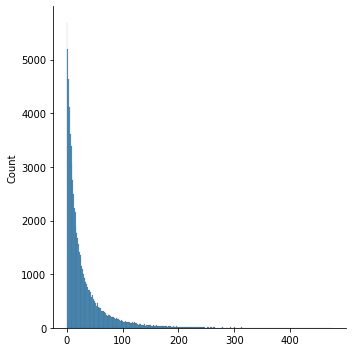

In [49]:
import seaborn as sns

waiting_times = np.round([p.waiting_time() for p in c[0]], 2)

sns.displot(waiting_times[waiting_times > 0])

In [50]:
waiting_times.max()

475.02

In [51]:
from joblib import dump, load

#only really need to save the drivers for the animation
dump(c[1], 'driver_history')

['driver_history']

In [ ]:
#shitty version, don't use

#inserts event into queue, based on time
def insert_event(event, queue, stats_dict, stats_name, time_index = -1):
    t = event[time_index]
    
    tic = time.time()
    i = 0
    for e in queue:
        if t < e[time_index]:
            break
        i += 1
    queue.insert(i, event)
    toc = time.time()
    stats_dict[stats_name][0] += toc - tic
    stats_dict[stats_name][1] += 1

#assumes customer info mat is a dataframe with idx, time, pulocationid, dolocationid, service
def return_customer_info(idx, cust_info_mat = arrivals):
    sr = cust_info_mat.loc[idx]
    return idx, sr.time, sr.pulocationid, sr.dolocationid, sr.service
    
#generates a random movement time assuming service times are exponentially distributed
def generate_movement_time(pu, do, travel_times, stats_dict, stats_name):
    
    #try except just catches the case where there's no pickup data for a zone
    tic = time.time()
    try:
        mm = travel_times.loc[pu, do]
        if not pd.isnull(mm):
            mt = np.random.exponential(mm)
        else:
            #if there's no data for that specific pu->do, just use the mean of the pu zone trips
            mt = np.random.exponential(travel_times.loc[pu].mean())
    except:
        #if no data on that pickup zone, use the mean of the dropoff zone
        mt = np.random.exponential(travel_times.loc[:,do].mean())
    toc = time.time()
    stats_dict[stats_name][0] += toc - tic
    stats_dict[stats_name][1] += 1

    return mt

#update driver location (and where they are going), the drivers in each zone, and the number of drivers in each zone (if needed)
def update_driver_information(driver_id, dropoff_location, z_count_update, t, p,
                              d_locations, d_movements, z_drivers, z_counts,
                              stats_dict, stats_name):
    tic = time.time()
    current_location = d_locations[driver_id]
    z_drivers[current_location].remove(driver_id)
    z_drivers[dropoff_location].add(driver_id)
    d_locations[driver_id] = dropoff_location
    
    d_movements[driver_id].append((t,dropoff_location,p))
    
    #if the driver leaves a location
    if z_count_update == -1:
        z_counts[current_location] -= 1
    
    #if the driver arrives at a location (and doesn't leave again)
    elif z_count_update == 1:
        z_counts[dropoff_location] += 1
    toc = time.time()
    stats_dict[stats_name][0] += toc - tic
    stats_dict[stats_name][1] += 1

def simulate_with_individual_drivers(arrivals, 
                                     driver_distribution = 'proportional',
                                     driver_count = 10000,
                                     odmatrix = trip_time_data,
                                     distributed_queue_count = 10, #speed option
                                    ):
    """event list: [
                   (driver id (-1 if customer arrival), 
                   (passenger id (-1 if no passenger),
                   (from location id, -1 if arrival),
                   (to location id, -1 if arrival),
                   (time of event (when the queue hits the event))
                   ]
       movement_queues essentially creates a bunch of queues to speed up inserting each created event into the event list
       can access the first event of each movement queue very quickly to check which queue to pop from
       the system also adds events to the minimum length queue to distribute the event load
    """
    negs = -1 * np.ones(arrivals.shape[0])
    arrival_queue = deque(np.c_[negs,
                             arrivals.index, 
                             negs,
                             negs,
                             arrivals.time])
    movement_queues = {i:deque() for i in range(distributed_queue_count)}
    
    #initialize driver queues
    driver_queues = {i:deque([]) for i in range(driver_count)}
    
    #initialize driver locations
    #in-between trip drivers have a value = -(zone where they are going to)
    #so -23 means the driver is going towards zone 23
    driver_locations = {}
    
    #to save the history of driver movements, save 
    #first the starting location (time = 0)
    #then each event afterwards:
    #1. time of movement 2. where they are / -where they going 3. customer id / -1
    driver_movements = {}
    
    #also keep track of the drivers in each zone (or on their way to each zone)
    zone_drivers = {i:set() for i in np.arange(-263, 264)}
    
    #for each zone, how many drivers are in there, not doing anything?
    zone_counts = {i:0 for i in np.arange(1,264)}
    
    #initialize passenger dep times
    passenger_departure_times = {}
    
    #assign driver locations
    """this driver assignment is flawed because it uses the arrivals, which you wouldn't actually know in real life
       a better way would be to just use the data previously gathered to generate driver distributions
       
       testing different distributions is also necessary for sensitivity analysis, so some ideas:
       1. distributing uniformly across all zones (obviously not the best strategy, but maybe a good baseline)
       2. place drivers in the top 10 most popular zones
       
       something to keep in mind this whole time though is that drivers are not the same as servers,
       uber's more of a platform and drivers can accept/reject trips and also have daily schedules for driving,
       adding an additional layer of complexity that probably needs to be added on later
    """
    if driver_distribution == 'proportional':
        
        #number of drivers per zone
        dcounts = driver_count * (arrivals.groupby('pulocationid')['time'].count() / arrivals.shape[0])
        dcounts = np.floor(dcounts)
        t = 0
        for i in dcounts.index:
            for d in range(int(dcounts.loc[i])):
                driver_locations[t] = i
                zone_drivers[i].add(t)
                driver_movements[t] = deque()
                driver_movements[t].appendleft((0,i,-1))
                t += 1
        #the remainder of drivers not included in the np.floor operation above get added randomly
        while t < driver_count:
            z = np.random.choice(np.arange(1,264))
            driver_locations[t] = z
            zone_drivers[z].add(t)
            driver_movements[t] = deque()
            driver_movements[t].appendleft((0,z,-1))
            t += 1
    
    #updating the number of drivers in each zone based on previous assignments
    for d in driver_locations:
        zone_counts[driver_locations[d]] += 1
    
    #for diagonising the system if there's any problems with speed
    stats = {'time_to_determine_queue':[0,0],
             'time_to_insert_events':[0,0],
             'update_driver_information':[0,0],
             'movement_time_calculation':[0,0]}
    
    #progress bar based on the # of customers processed
    pbar = tqdm(total = arrivals.shape[0], position = 0, leave = True)
    
    #second part of this conditional checks if any of the movement queues are of nonzero length
    while len(arrival_queue) > 0 or (np.array([len(i[1]) for i in movement_queues.items()]) > 0).any():
        
        """this entire bit is for speeding up the event list by adding several queues
        """
        #pick the minimum length movement queue to add to if needed
        tic = time.time()
        active_queue = min(movement_queues.keys(), key = lambda k: len(movement_queues[k]))
        active_queue = movement_queues[active_queue]
        
        #discover the first time value of each movement queue and the arrival queue (if the length is nonzero)
        first_times = [(k,v[0][-1]) if len(v) > 0 else (k,1000000) for k,v in movement_queues.items()]
        first_times.append(('a',arrival_queue[0][-1]) if len(arrival_queue) > 0 else ('a',1000000))
        
        #choose the right queue to take from based on the first times
        min_key = min(first_times, key = lambda i: i[1])
        toc = time.time()
        stats['time_to_determine_queue'][0] += toc - tic
        stats['time_to_determine_queue'][1] += 1
        if min_key[0] == 'a':
            event = arrival_queue.popleft()
        else:
            event = movement_queues[min_key[0]].popleft()
        
        #for interpretation purposes
        driver_id = int(event[0])
        pass_id = int(event[1])
        pickup = int(event[2])
        dropoff = int(event[3])
        etime = event[4]        
        
        #if passenger arrival
        if driver_id == -1:
            cust_id, pu_time, pu, do, serv = return_customer_info(pass_id)
            
            """driver selection
               pick a random driver in the beginning
               check if there's an available driver in the zone, break if there is
               otherwise it'll choose a driver coming towards the zone
               
               better version (not implemented):
               pick driver with lowest queue length out of the available ones
               pick drivers that are closest (would require more storage)
            """
            chosen_driver = np.random.randint(0, driver_count)
            drivers_coming_to_zone = tuple(zone_drivers[-1 * pu])
            drivers_in_zone = tuple(zone_drivers[pu])
            
            if len(drivers_in_zone) > 0:
                chosen_driver = np.random.choice(drivers_in_zone)
                #if the customer is in the zone, then immediately generate the departure event
                departure_event = np.array([chosen_driver,
                                            cust_id,
                                            pu,
                                            do,
                                            pu_time + serv])
                insert_event(departure_event, active_queue, stats, 'time_to_insert_events')
                update_driver_information(chosen_driver, -1 * do, -1, pu_time, cust_id,
                                          driver_locations, driver_movements, zone_drivers, zone_counts,
                                          stats, 'update_driver_information')
                                        
            else: #add to the chosen driver's queue, make the driver move if the driver is free
                
                if len(drivers_coming_to_zone) > 0:
                    chosen_driver = np.random.choice(drivers_coming_to_zone)
                
                driver_queues[chosen_driver].append(cust_id)
                
                d_loc = driver_locations[chosen_driver]
                if d_loc > 0:
                    #generate a driver movement event
                    move_time = generate_movement_time(d_loc, pu, odmatrix, stats, 'movement_time_calculation')
                    movement_event = np.array([chosen_driver,
                                               -1,
                                               d_loc,
                                               pu,
                                               pu_time + move_time])
                    insert_event(movement_event, active_queue, stats, 'time_to_insert_events')
                    update_driver_information(chosen_driver, -1 * pu, -1, pu_time, -1,
                                              driver_locations, driver_movements, zone_drivers, zone_counts,
                                              stats, 'update_driver_information')
                
        #anything else involves a driver
        else:
            
            #if passenger departure
            if pass_id != -1:
                #first record the departure
                passenger_departure_times[pass_id] = etime
                pbar.update(1)
                
                #deal with driver's queued customer
                if len(driver_queues[driver_id]) > 0:
                    
                    next_customer = driver_queues[driver_id][0]
                    cust_id, pu_time, pu, do, serv = return_customer_info(next_customer)
                    
                    #if the queued customer is in the current zone
                    if pu == dropoff:
                        #add a departure event
                        driver_queues[driver_id].popleft()
                        departure_event = np.array([driver_id,
                                                    cust_id,
                                                    pu,
                                                    do,
                                                    etime + serv])
                        insert_event(departure_event, active_queue, stats, 'time_to_insert_events')
                        update_driver_information(driver_id, -1 * do, 0, etime, cust_id,
                                                  driver_locations, driver_movements, zone_drivers, zone_counts,
                                                  stats, 'update_driver_information')
                        
                    else:
                        #add a driver movement event
                        move_time = generate_movement_time(dropoff, pu, odmatrix, stats, 'movement_time_calculation')
                        movement_event = np.array([driver_id,
                                                   -1,
                                                   dropoff,
                                                   pu,
                                                   etime + move_time])
                        insert_event(movement_event, active_queue, stats, 'time_to_insert_events')
                        update_driver_information(driver_id, -1 * pu, 0, etime, -1,
                                                  driver_locations, driver_movements, zone_drivers, zone_counts,
                                                  stats, 'update_driver_information')
                
                else:
                    """if no queued customer, just leave the driver at the zone they went to
                
                    a more realistic algorithm would be to move the driver towards anticipated demand
                    """
                    update_driver_information(driver_id, dropoff, 1, etime, -1,
                                              driver_locations, driver_movements, zone_drivers, zone_counts,
                                              stats, 'update_driver_information')       
            
            #if driver only movement
            else:
                
                #deal with queued customer who will always be in the zone
                if len(driver_queues[driver_id]) > 0:
                    
                    next_customer = driver_queues[driver_id].popleft()
                    cust_id, pu_time, pu, do, serv = return_customer_info(next_customer)
                    
                    departure_event = np.array([driver_id,
                                                cust_id,
                                                dropoff,
                                                do,
                                                etime + serv])
                    insert_event(departure_event, active_queue, stats, 'time_to_insert_events')
                    update_driver_information(driver_id, -1 * do, 0, etime, cust_id,
                                              driver_locations, driver_movements, zone_drivers, zone_counts,
                                              stats, 'update_driver_information')
                    
                else:
                    """if no queued customer, just leave the driver at the zone they went to
                
                   a more realistic algorithm would be to move the driver towards anticipated demand
                    """  
                    update_driver_information(driver_id, dropoff, 1, etime, -1,
                                              driver_locations, driver_movements, zone_drivers, zone_counts,
                                              stats, 'update_driver_information')
                     
                
    pbar.close()
    
    return passenger_departure_times, driver_movements, stats


In [ ]:
arrival_partition = arrivals

customer_departures = simulate_with_individual_drivers(arrival_partition, driver_count = 5000, distributed_queue_count = 20)

In [ ]:
customer_departures[2]

In [ ]:
wait_times = (pd.Series(customer_departures[0]).sort_index() - arrival_partition.time - arrival_partition.service).round(3)

In [ ]:
print(wait_times.mean())


In [ ]:
import seaborn as sns

sns.displot(wait_times)


In [ ]:
import sys

#recursive get size of the driver movements
s = sys.getsizeof(customer_departures[1])
for k,v in customer_departures[1].items():
    s += sys.getsizeof(v)
    s += sum([sys.getsizeof(t) for t in v])
    s += sum([sum([sys.getsizeof(i) for i in t]) for t in v])
print(s / 1024 ** 3)

In [ ]:
from joblib import dump

dump(customer_departures[1], 'driver_movements_5000')